In [15]:
# ==============================================================================
# CELL 1: SETUP, CONFIG, AND FUNCTION DEFINITIONS
# ==============================================================================
# This cell contains all necessary imports, the final corrected configuration,
# data loading logic using ImageFolder, and all helper functions for training
# and analysis.
# ==============================================================================

# --- 0. Import Required Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.models as models
import torchvision.datasets as datasets
from pathlib import Path
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Evaluation Script Initialized.")

# --- 1. Configuration (FINAL CORRECTED PATHS) ---
CONFIG = {
    # Paths pointing to the dedicated Kaggle Datasets for each model
    'byol_model_path': "/kaggle/input/byol-resnet18-10pct-weights/byol_best_encoder_stable.pth",
    'barlow_model_path': "/kaggle/input/barlow-resnet18-10pct-weights/barlow_best_encoder_10pct.pth",
    
    # Base path for EuroSAT, containing train/test/val subdirectories
    'eurosat_base_path': "/kaggle/input/rgbeurosat/RBG",
    
    # Linear Probing settings
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 0.01,
    
    # System settings
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 2,
}

# --- 2. Data Preparation for EuroSAT ---
data_transform = T.Compose([
    T.Resize((224, 224), antialias=True),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_path = os.path.join(CONFIG['eurosat_base_path'], 'train')
val_path = os.path.join(CONFIG['eurosat_base_path'], 'val')
if not os.path.exists(val_path):
    print("Validation set 'val' not found, using 'test' set for validation.")
    val_path = os.path.join(CONFIG['eurosat_base_path'], 'test')

train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

print(f"EuroSAT Dataset Prepared using ImageFolder:")
print(f"  Found {num_classes} classes: {class_names}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")


# --- 3. Model & Function Definitions ---
class LinearEvaluationModel(nn.Module):
    def __init__(self, pretrained_encoder_path, num_classes):
        super().__init__()
        self.encoder = models.resnet18(weights=None)
        encoder_output_dim = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        if pretrained_encoder_path and os.path.exists(pretrained_encoder_path):
            print(f"Loading pre-trained weights from: {pretrained_encoder_path}")
            state_dict = torch.load(pretrained_encoder_path, map_location='cpu')
            self.encoder.load_state_dict(state_dict, strict=False)
        else:
            print(f"Path not found or not provided: {pretrained_encoder_path}. Initializing encoder from scratch.")
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(encoder_output_dim, num_classes)
    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        return self.classifier(features)

def train_and_evaluate(model, model_name, train_from_scratch=False):
    print(f"\n--- Evaluating: {model_name} ---")
    device = CONFIG['device']
    model.to(device)
    params_to_train = model.classifier.parameters()
    if train_from_scratch:
        print("Training from scratch: Unfreezing the entire model.")
        for param in model.parameters(): param.requires_grad = True
        params_to_train = model.parameters()
    else:
        print("Linear Probing: Training only the classifier head.")
        
    optimizer = optim.Adam(params_to_train, lr=CONFIG['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_accuracy = 0.0

    for epoch in range(CONFIG['epochs']):
        model.train()
        if not train_from_scratch: model.encoder.eval()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_accuracy = 100 * train_correct / train_total
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_accuracy)
        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
        val_accuracy = 100 * val_correct / val_total
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_accuracy)
        if val_accuracy > best_accuracy: best_accuracy = val_accuracy
        print(f"Epoch {epoch+1} - Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f} | Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        
    print(f"-> Best validation accuracy for {model_name}: {best_accuracy:.2f}%")
    return best_accuracy, history, all_labels, all_preds

def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Training History for {model_name}', fontsize=16)
    ax1.plot(history['train_loss'], label='Train Loss'); ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss over Epochs'); ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
    ax2.plot(history['train_acc'], label='Train Accuracy'); ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy over Epochs'); ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy (%)'); ax2.legend(); ax2.grid(True)
    plt.show()

def display_classification_report_and_matrix(labels, preds, model_name, class_names):
    print(f"\n--- Detailed Report for {model_name} ---")
    print(classification_report(labels, preds, target_names=class_names))
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

print("\n--- All functions and configurations are ready. ---")

Evaluation Script Initialized.
EuroSAT Dataset Prepared using ImageFolder:
  Found 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
  Training samples: 21600
  Validation samples: 2700

--- All functions and configurations are ready. ---


In [18]:
# ==========================================================
# CELL 2: EVALUATE BYOL
# ==========================================================
gc.collect(); torch.cuda.empty_cache()

byol_eval_model = LinearEvaluationModel(CONFIG['byol_model_path'], num_classes)
byol_accuracy, byol_hist, byol_labels, byol_preds = train_and_evaluate(
    model=byol_eval_model, 
    model_name="BYOL Pre-trained Encoder", 
    loader_train=train_loader, 
    loader_val=val_loader,
    train_from_scratch=False  # Explicitly name the argument
)

Loading pre-trained weights from: /kaggle/input/byol-resnet18-10pct-weights/byol_best_encoder_stable.pth


TypeError: train_and_evaluate() got an unexpected keyword argument 'loader_train'

In [ ]:
# ==========================================================
# CELL 2: SANITY CHECK & MODEL EVALUATIONS
# ==========================================================
if __name__ == '__main__':
    # --- PRE-RUN SANITY CHECK ---
    print("--- Sanity Checking File Paths ---")
    paths_to_check = { "BYOL Model": CONFIG['byol_model_path'],
                       "Barlow Twins Model": CONFIG['barlow_model_path'],
                       "EuroSAT Train Dir": os.path.join(CONFIG['eurosat_base_path'], 'train') }
    all_paths_ok = True
    for name, path in paths_to_check.items():
        if os.path.exists(path): print(f"✅ OK: Found {name} at: {path}")
        else: print(f"❌ ERROR: Could not find {name} at: {path}"); all_paths_ok = False
            
    if not all_paths_ok:
        print("\nHalting execution. Please correct the paths in the CONFIG section.")
    else:
        print("--- All paths verified. Starting evaluation. ---\n")
        
        # --- MODEL EVALUATION ---
        gc.collect(); torch.cuda.empty_cache()
        
        # Evaluate BYOL
        byol_eval_model = LinearEvaluationModel(CONFIG['byol_model_path'], num_classes)
        byol_accuracy, byol_hist, byol_labels, byol_preds = train_and_evaluate(byol_eval_model, "BYOL Pre-trained Encoder")
        
        # Evaluate Barlow Twins
        barlow_eval_model = LinearEvaluationModel(CONFIG['barlow_model_path'], num_classes)
        barlow_accuracy, barlow_hist, barlow_labels, barlow_preds = train_and_evaluate(barlow_eval_model, "Barlow Twins Pre-trained Encoder")
        
        # Evaluate from-scratch baseline
        scratch_model = LinearEvaluationModel(None, num_classes)
        scratch_accuracy, scratch_hist, scratch_labels, scratch_preds = train_and_evaluate(scratch_model, "ResNet-18 (Trained from Scratch)", train_from_scratch=True)
        
        # --- FINAL RESULTS & ANALYSIS ---
        results = { "BYOL": byol_accuracy, "Barlow Twins": barlow_accuracy, "From Scratch": scratch_accuracy }
        histories = { "BYOL": byol_hist, "Barlow Twins": barlow_hist, "From Scratch": scratch_hist }
        predictions = { "BYOL": (byol_labels, byol_preds), "Barlow Twins": (barlow_labels, barlow_preds), "From Scratch": (scratch_labels, scratch_preds) }

        # Display detailed analysis for each model
        for model_name in results.keys():
            plot_training_history(histories[model_name], model_name)
            labels, preds = predictions[model_name]
            display_classification_report_and_matrix(labels, preds, model_name, class_names)
        
        # Final summary table
        print("\n" + "="*55)
        print("      FINAL LINEAR PROBING RESULTS ON EUROSAT")
        print("="*55)
        print(f"  ResNet-18 (from Scratch):     {scratch_accuracy:.2f}%")
        print(f"  BYOL Pre-trained Encoder:     {byol_accuracy:.2f}%")
        print(f"  Barlow Twins Pre-trained:   {barlow_accuracy:.2f}%")
        print("="*55)

--- Sanity Checking File Paths ---
✅ OK: Found BYOL Model at: /kaggle/input/byol-resnet18-10pct-weights/byol_best_encoder_stable.pth
✅ OK: Found Barlow Twins Model at: /kaggle/input/barlow-resnet18-10pct-weights/barlow_best_encoder_10pct.pth
✅ OK: Found EuroSAT Train Dir at: /kaggle/input/rgbeurosat/RBG/train
--- All paths verified. Starting evaluation. ---

Loading pre-trained weights from: /kaggle/input/byol-resnet18-10pct-weights/byol_best_encoder_stable.pth

--- Evaluating: BYOL Pre-trained Encoder ---
Linear Probing: Training only the classifier head.


Epoch 1/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.1276, Val Loss: 0.8247 | Train Acc: 62.29%, Val Acc: 68.00%


Epoch 2/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.7929, Val Loss: 0.7150 | Train Acc: 72.15%, Val Acc: 74.00%


Epoch 3/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.7342, Val Loss: 0.7810 | Train Acc: 73.91%, Val Acc: 72.56%


Epoch 4/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.7206, Val Loss: 0.7113 | Train Acc: 74.26%, Val Acc: 73.70%


Epoch 5/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.6697, Val Loss: 0.6568 | Train Acc: 76.01%, Val Acc: 75.81%


Epoch 6/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.6817, Val Loss: 0.6836 | Train Acc: 75.40%, Val Acc: 74.48%


Epoch 7/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.6564, Val Loss: 0.6069 | Train Acc: 76.40%, Val Acc: 77.37%


Epoch 8/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.6239, Val Loss: 0.6205 | Train Acc: 77.24%, Val Acc: 76.59%


Epoch 9/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.6410, Val Loss: 0.6280 | Train Acc: 77.08%, Val Acc: 77.44%


Epoch 10/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.6220, Val Loss: 0.5954 | Train Acc: 77.37%, Val Acc: 76.85%


Epoch 11/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 0.6196, Val Loss: 0.6130 | Train Acc: 77.81%, Val Acc: 77.19%


Epoch 12/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 0.5884, Val Loss: 0.6029 | Train Acc: 78.69%, Val Acc: 77.22%


Epoch 13/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.5889, Val Loss: 0.5788 | Train Acc: 78.75%, Val Acc: 77.93%


Epoch 14/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.5747, Val Loss: 0.6082 | Train Acc: 79.37%, Val Acc: 77.63%


Epoch 15/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.5846, Val Loss: 0.6460 | Train Acc: 79.12%, Val Acc: 76.59%


Epoch 16/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 16 - Train Loss: 0.5776, Val Loss: 0.5796 | Train Acc: 79.32%, Val Acc: 78.56%


Epoch 17/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 17 - Train Loss: 0.5542, Val Loss: 0.5423 | Train Acc: 80.08%, Val Acc: 79.04%


Epoch 18/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 18 - Train Loss: 0.5714, Val Loss: 0.5353 | Train Acc: 79.41%, Val Acc: 79.78%


Epoch 19/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 19 - Train Loss: 0.5576, Val Loss: 0.5629 | Train Acc: 80.21%, Val Acc: 78.59%


Epoch 20/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 20 - Train Loss: 0.5686, Val Loss: 0.6397 | Train Acc: 79.58%, Val Acc: 76.26%
-> Best validation accuracy for BYOL Pre-trained Encoder: 79.78%
Loading pre-trained weights from: /kaggle/input/barlow-resnet18-10pct-weights/barlow_best_encoder_10pct.pth

--- Evaluating: Barlow Twins Pre-trained Encoder ---
Linear Probing: Training only the classifier head.


Epoch 1/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.8815, Val Loss: 1.5927 | Train Acc: 34.36%, Val Acc: 39.85%


Epoch 2/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.6046, Val Loss: 1.6157 | Train Acc: 39.96%, Val Acc: 42.41%


Epoch 3/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.5396, Val Loss: 1.5238 | Train Acc: 43.60%, Val Acc: 40.67%


Epoch 4/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 1.5053, Val Loss: 1.5360 | Train Acc: 45.15%, Val Acc: 44.15%


Epoch 5/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.4720, Val Loss: 1.4730 | Train Acc: 46.35%, Val Acc: 49.15%


Epoch 6/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 1.4796, Val Loss: 1.3786 | Train Acc: 46.52%, Val Acc: 51.26%


Epoch 7/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 1.4325, Val Loss: 1.4089 | Train Acc: 48.06%, Val Acc: 49.93%


Epoch 8/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 1.4250, Val Loss: 1.4327 | Train Acc: 48.73%, Val Acc: 51.07%


Epoch 9/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 1.4021, Val Loss: 1.3776 | Train Acc: 48.89%, Val Acc: 50.96%


Epoch 10/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 1.4198, Val Loss: 1.3759 | Train Acc: 49.19%, Val Acc: 51.93%


Epoch 11/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 1.3919, Val Loss: 1.3671 | Train Acc: 49.60%, Val Acc: 49.70%


Epoch 12/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 1.3739, Val Loss: 1.4226 | Train Acc: 50.16%, Val Acc: 48.78%


Epoch 13/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 1.3906, Val Loss: 1.3487 | Train Acc: 50.38%, Val Acc: 52.26%


Epoch 14/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 1.3926, Val Loss: 1.3879 | Train Acc: 50.39%, Val Acc: 49.56%


Epoch 15/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 1.3406, Val Loss: 1.3601 | Train Acc: 52.00%, Val Acc: 52.48%


Epoch 16/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 16 - Train Loss: 1.3514, Val Loss: 1.3470 | Train Acc: 51.94%, Val Acc: 51.41%


Epoch 17/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 17 - Train Loss: 1.3187, Val Loss: 1.3689 | Train Acc: 52.69%, Val Acc: 52.41%


Epoch 18/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 18 - Train Loss: 1.3083, Val Loss: 1.2665 | Train Acc: 52.94%, Val Acc: 53.85%


Epoch 19/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 19 - Train Loss: 1.3444, Val Loss: 1.3421 | Train Acc: 52.05%, Val Acc: 52.93%


Epoch 20/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 20 - Train Loss: 1.3213, Val Loss: 1.3278 | Train Acc: 53.30%, Val Acc: 52.52%
-> Best validation accuracy for Barlow Twins Pre-trained Encoder: 53.85%
Path not found or not provided: None. Initializing encoder from scratch.

--- Evaluating: ResNet-18 (Trained from Scratch) ---
Training from scratch: Unfreezing the entire model.


Epoch 1/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.4468, Val Loss: 1.0933 | Train Acc: 51.14%, Val Acc: 62.74%


Epoch 2/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.0728, Val Loss: 0.9699 | Train Acc: 62.52%, Val Acc: 65.22%


Epoch 3/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.9816, Val Loss: 0.9930 | Train Acc: 65.34%, Val Acc: 62.44%


Epoch 4/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.9702, Val Loss: 0.9129 | Train Acc: 66.34%, Val Acc: 66.52%


Epoch 5/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.9073, Val Loss: 0.8953 | Train Acc: 68.01%, Val Acc: 66.63%


Epoch 6/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.8829, Val Loss: 0.8298 | Train Acc: 69.29%, Val Acc: 69.44%


Epoch 7/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.8576, Val Loss: 0.8628 | Train Acc: 69.62%, Val Acc: 69.56%


Epoch 8/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.8520, Val Loss: 0.8688 | Train Acc: 69.93%, Val Acc: 68.89%


Epoch 9/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.8314, Val Loss: 0.7767 | Train Acc: 70.44%, Val Acc: 72.15%


Epoch 10/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.8127, Val Loss: 0.7743 | Train Acc: 71.49%, Val Acc: 72.63%


Epoch 11/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

In [23]:
# ==========================================================
# RETRY: EVALUATE FROM-SCRATCH BASELINE (STABLE)
# ==========================================================
# This cell specifically retries the from-scratch training with
# num_workers=0 to prevent potential deadlocks during data loading.
# It assumes the previous cell with function and class definitions has been run.

print("--- Retrying evaluation for ResNet-18 (from Scratch) ---")
gc.collect()
torch.cuda.empty_cache()

# --- Redefine the training function to accept dataloader arguments ---
def train_and_evaluate(model, model_name, loader_train, loader_val, train_from_scratch=False):
    print(f"\n--- Evaluating: {model_name} ---")
    device = CONFIG['device']
    model.to(device)
    
    params_to_train = model.classifier.parameters()
    if train_from_scratch:
        print("Training from scratch: Unfreezing the entire model.")
        for param in model.parameters():
            param.requires_grad = True
        params_to_train = model.parameters()
    else:
        print("Linear Probing: Training only the classifier head.")
        
    optimizer = optim.Adam(params_to_train, lr=CONFIG['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_accuracy = 0.0

    for epoch in range(CONFIG['epochs']):
        model.train()
        if not train_from_scratch:
            model.encoder.eval()
        
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in tqdm(loader_train, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        history['train_loss'].append(running_loss / len(loader_train))
        history['train_acc'].append(train_accuracy)
        
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        all_labels, all_preds = [], []
        with torch.no_grad():
            for inputs, labels in loader_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                
        val_accuracy = 100 * correct_val / total_val
        history['val_loss'].append(val_loss / len(loader_val))
        history['val_acc'].append(val_accuracy)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            
        print(f"Epoch {epoch+1} - Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f} | Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
        
    print(f"-> Best validation accuracy for {model_name}: {best_accuracy:.2f}%")
    return best_accuracy, history, all_labels, all_preds
# --------------------------------------------------------------------------

# Create new DataLoaders with num_workers=0 for this specific run
print("Creating new DataLoaders with num_workers=0...")
scratch_train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
scratch_val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
print("DataLoaders created.")

# Initialize the scratch model
scratch_model = LinearEvaluationModel(None, num_classes)

# Run the evaluation for the scratch model ONLY
scratch_accuracy, scratch_hist, scratch_labels, scratch_preds = train_and_evaluate(
    model=scratch_model, 
    model_name="ResNet-18 (Trained from Scratch)", 
    loader_train=scratch_train_loader,
    loader_val=scratch_val_loader,
    train_from_scratch=True
)

print("\n--- Scratch Model Evaluation Finished ---")
print(f"Final Accuracy for Scratch Model: {scratch_accuracy:.2f}%")

--- Retrying evaluation for ResNet-18 (from Scratch) ---
Creating new DataLoaders with num_workers=0...
DataLoaders created.
Path not found or not provided: None. Initializing encoder from scratch.

--- Evaluating: ResNet-18 (Trained from Scratch) ---
Training from scratch: Unfreezing the entire model.


Epoch 1/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.6753, Val Loss: 1.1371 | Train Acc: 46.91%, Val Acc: 59.74%


Epoch 2/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.1008, Val Loss: 1.0176 | Train Acc: 61.98%, Val Acc: 63.33%


Epoch 3/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.0109, Val Loss: 0.9821 | Train Acc: 64.13%, Val Acc: 63.11%


Epoch 4/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.9608, Val Loss: 0.9344 | Train Acc: 66.45%, Val Acc: 65.63%


Epoch 5/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.9235, Val Loss: 0.9041 | Train Acc: 67.64%, Val Acc: 67.22%


Epoch 6/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.9101, Val Loss: 0.8594 | Train Acc: 67.67%, Val Acc: 67.85%


Epoch 7/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.8843, Val Loss: 0.8672 | Train Acc: 68.88%, Val Acc: 68.67%


Epoch 8/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.8909, Val Loss: 0.8669 | Train Acc: 68.53%, Val Acc: 66.81%


Epoch 9/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.8312, Val Loss: 0.7957 | Train Acc: 70.90%, Val Acc: 72.22%


Epoch 10/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.8165, Val Loss: 0.7791 | Train Acc: 71.15%, Val Acc: 72.41%


Epoch 11/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 11 - Train Loss: 0.8195, Val Loss: 0.8021 | Train Acc: 71.42%, Val Acc: 70.48%


Epoch 12/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 12 - Train Loss: 0.8198, Val Loss: 0.8934 | Train Acc: 71.12%, Val Acc: 68.04%


Epoch 13/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 13 - Train Loss: 0.8033, Val Loss: 0.7857 | Train Acc: 71.57%, Val Acc: 71.07%


Epoch 14/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 14 - Train Loss: 0.7985, Val Loss: 0.7864 | Train Acc: 71.57%, Val Acc: 70.44%


Epoch 15/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 15 - Train Loss: 0.8094, Val Loss: 0.7770 | Train Acc: 71.57%, Val Acc: 70.96%


Epoch 16/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 16 - Train Loss: 0.7771, Val Loss: 0.7834 | Train Acc: 72.33%, Val Acc: 71.78%


Epoch 17/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 17 - Train Loss: 0.7603, Val Loss: 0.7548 | Train Acc: 73.20%, Val Acc: 72.56%


Epoch 18/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 18 - Train Loss: 0.7554, Val Loss: 0.8031 | Train Acc: 73.10%, Val Acc: 71.22%


Epoch 19/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 19 - Train Loss: 0.7646, Val Loss: 0.7567 | Train Acc: 72.94%, Val Acc: 72.96%


Epoch 20/20 [Train]:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch 20 - Train Loss: 0.7891, Val Loss: 0.8527 | Train Acc: 72.31%, Val Acc: 68.74%
-> Best validation accuracy for ResNet-18 (Trained from Scratch): 72.96%

--- Scratch Model Evaluation Finished ---
Final Accuracy for Scratch Model: 72.96%



==================== BYOL ANALYSIS ====================


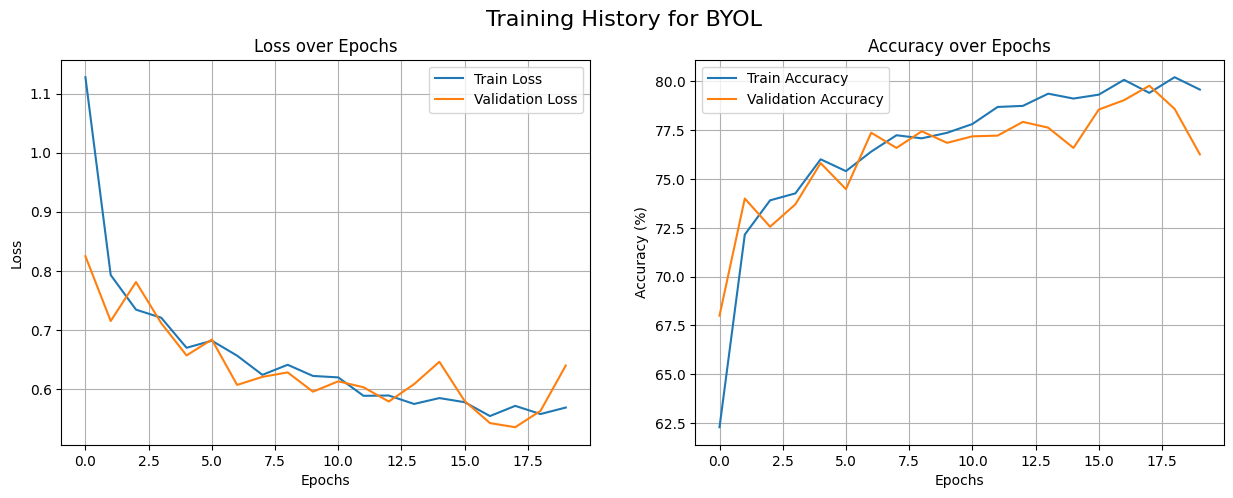


--- Detailed Report for BYOL ---
                      precision    recall  f1-score   support

          AnnualCrop       0.73      0.91      0.81       300
              Forest       0.99      0.64      0.78       300
HerbaceousVegetation       0.77      0.66      0.71       300
             Highway       0.62      0.29      0.40       250
          Industrial       0.97      0.83      0.89       250
             Pasture       0.73      0.85      0.79       200
       PermanentCrop       0.59      0.79      0.68       250
         Residential       0.88      0.97      0.92       300
               River       0.61      0.66      0.64       250
             SeaLake       0.77      0.97      0.86       300

            accuracy                           0.76      2700
           macro avg       0.77      0.76      0.75      2700
        weighted avg       0.77      0.76      0.75      2700



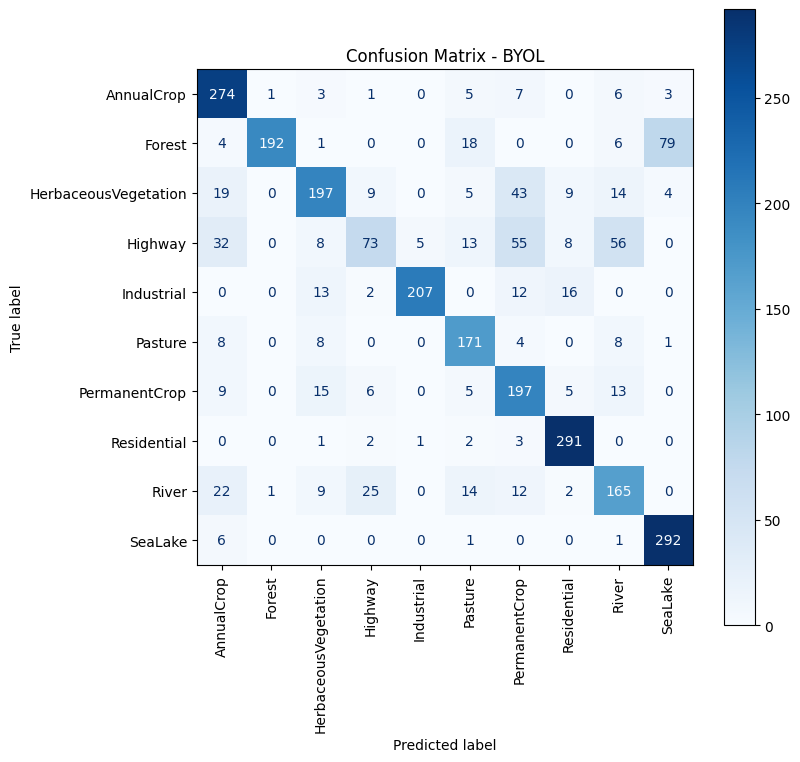


==================== BARLOW TWINS ANALYSIS ====================


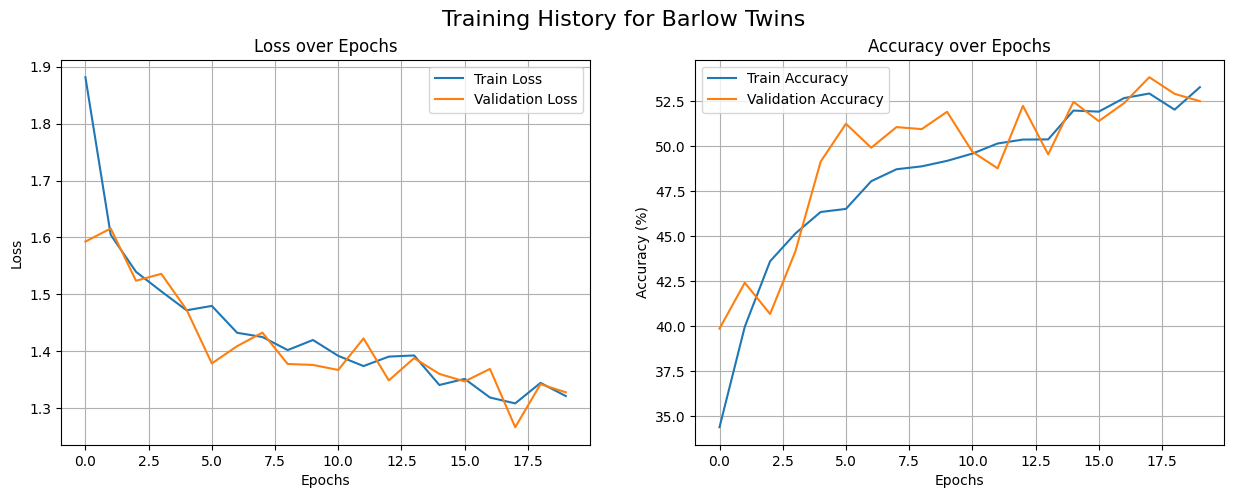


--- Detailed Report for Barlow Twins ---
                      precision    recall  f1-score   support

          AnnualCrop       0.58      0.51      0.54       300
              Forest       0.80      0.83      0.81       300
HerbaceousVegetation       0.42      0.46      0.44       300
             Highway       0.50      0.02      0.05       250
          Industrial       0.76      0.85      0.80       250
             Pasture       0.72      0.24      0.37       200
       PermanentCrop       0.37      0.52      0.43       250
         Residential       0.67      0.34      0.45       300
               River       0.26      0.75      0.39       250
             SeaLake       0.88      0.64      0.74       300

            accuracy                           0.53      2700
           macro avg       0.60      0.52      0.50      2700
        weighted avg       0.60      0.53      0.51      2700



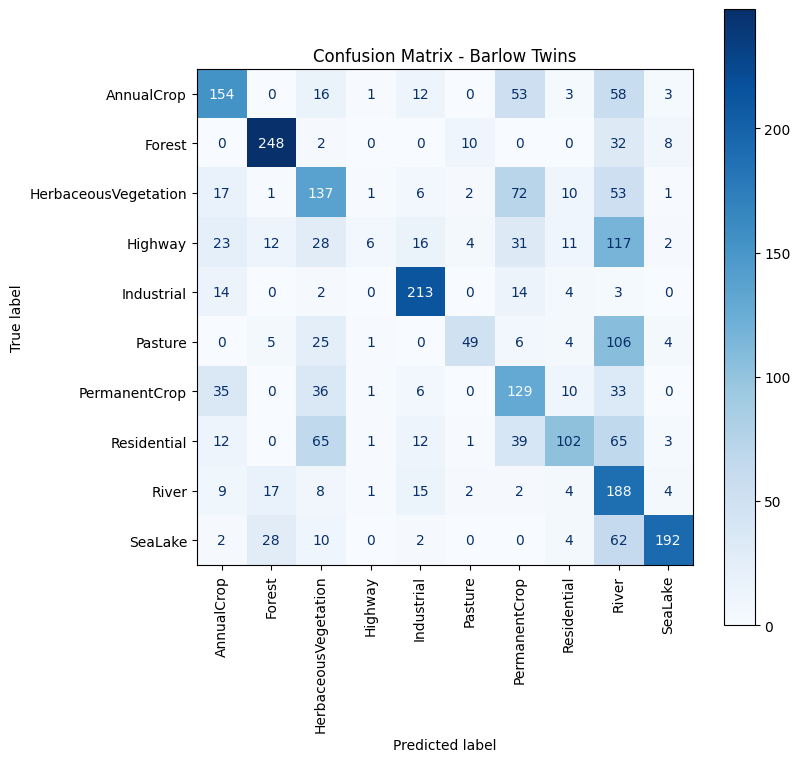


==================== FROM-SCRATCH ANALYSIS ====================


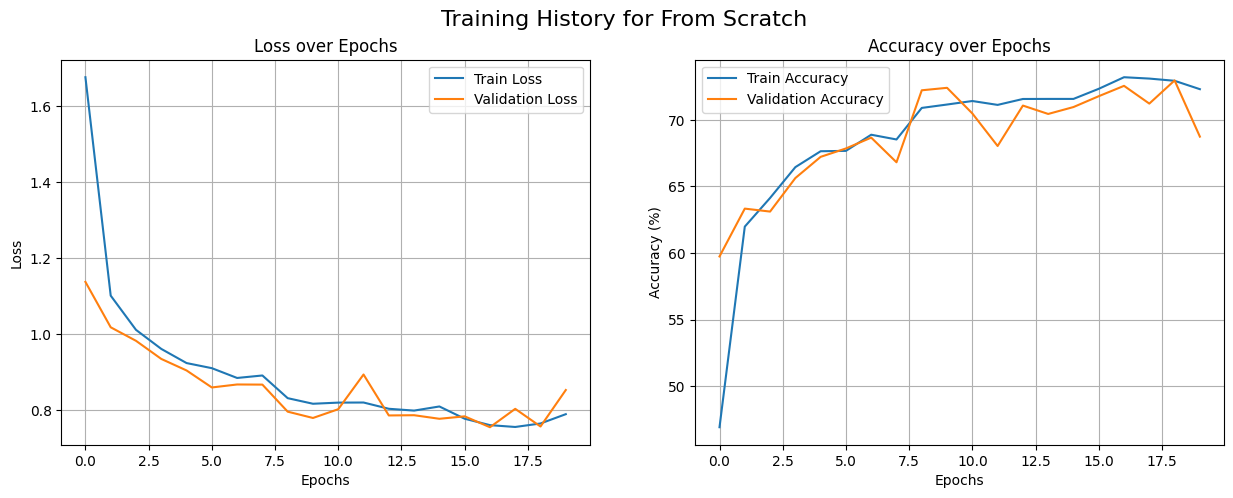


--- Detailed Report for From Scratch ---
                      precision    recall  f1-score   support

          AnnualCrop       0.85      0.62      0.72       300
              Forest       0.95      0.86      0.90       300
HerbaceousVegetation       0.49      0.71      0.58       300
             Highway       0.54      0.24      0.34       250
          Industrial       0.97      0.67      0.79       250
             Pasture       0.60      0.88      0.72       200
       PermanentCrop       0.73      0.39      0.51       250
         Residential       0.52      0.96      0.67       300
               River       0.65      0.56      0.60       250
             SeaLake       0.92      0.90      0.91       300

            accuracy                           0.69      2700
           macro avg       0.72      0.68      0.67      2700
        weighted avg       0.73      0.69      0.68      2700



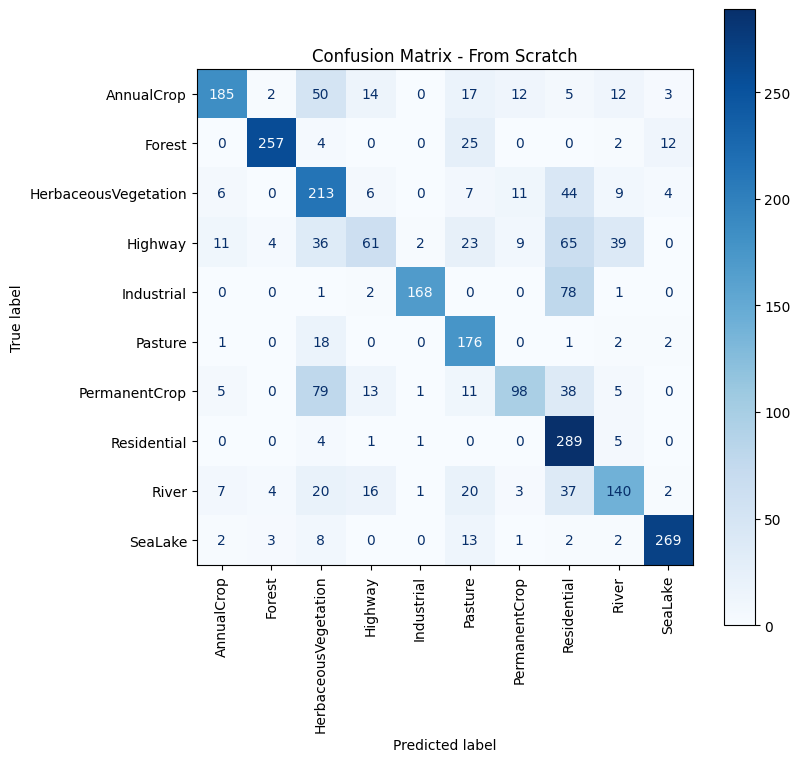


      FINAL LINEAR PROBING RESULTS ON EUROSAT
  ResNet-18 (from Scratch):     72.96%
  BYOL Pre-trained Encoder:     79.78%
  Barlow Twins Pre-trained:   53.85%


In [24]:
# ==========================================================
# FINAL CELL: RESULTS & VISUAL ANALYSIS
# ==========================================================
# This cell uses the results from the previous cells to generate
# all plots and reports for the final analysis.
# ==========================================================

# Display detailed analysis for each model
print("\n" + "="*20 + " BYOL ANALYSIS " + "="*20)
plot_training_history(byol_hist, "BYOL")
display_classification_report_and_matrix(byol_labels, byol_preds, "BYOL", class_names)

print("\n" + "="*20 + " BARLOW TWINS ANALYSIS " + "="*20)
plot_training_history(barlow_hist, "Barlow Twins")
display_classification_report_and_matrix(barlow_labels, barlow_preds, "Barlow Twins", class_names)

print("\n" + "="*20 + " FROM-SCRATCH ANALYSIS " + "="*20)
plot_training_history(scratch_hist, "From Scratch")
display_classification_report_and_matrix(scratch_labels, scratch_preds, "From Scratch", class_names)

# Final summary table
print("\n" + "="*55)
print("      FINAL LINEAR PROBING RESULTS ON EUROSAT")
print("="*55)
print(f"  ResNet-18 (from Scratch):     {scratch_accuracy:.2f}%")
print(f"  BYOL Pre-trained Encoder:     {byol_accuracy:.2f}%")
print(f"  Barlow Twins Pre-trained:   {barlow_accuracy:.2f}%")
print("="*55)